# Imports

In [56]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import transforms

from medmnist import BloodMNIST, INFO

import argparse
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
import json
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

data_flag = "bloodmnist"
info = INFO[data_flag]
n_classes = len(info["label"])
print("Classes:", n_classes, info["label"])

Device: cuda
Classes: 8 {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}


In [57]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])


# Plot Funtions

In [58]:
def plot(x, y, ylabel="", name=""):
    plt.clf()
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.plot(list(x), y)
    plt.savefig(f"{name}.pdf", bbox_inches="tight")


In [59]:
def plot_compare(x, series_dict, ylabel="", title="", filename="compare"):
    plt.clf()
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    for label, y in series_dict.items():
        plt.plot(list(x), y, label=label)
    plt.legend()
    plt.savefig(f"{filename}.pdf", bbox_inches="tight")

# CNN model

In [60]:
class CNN(nn.Module):
    def __init__(self, num_classes=8, use_pool=True):
        super().__init__()
        self.use_pool = use_pool

        # Convs iguais para os dois cenários
        self.conv1 = nn.Conv2d(3, 32, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # Heads diferentes porque o flatten muda
        self.fc1_pool = nn.Linear(128 * 3 * 3, 256)
        self.fc2_pool = nn.Linear(256, num_classes)

        self.fc1_nopool = nn.Linear(128 * 28 * 28, 256)
        self.fc2_nopool = nn.Linear(256, num_classes)

    def forward(self, x, use_pool=None):
        if use_pool is None:
            use_pool = self.use_pool

        x = F.relu(self.conv1(x))
        if use_pool:
            x = self.pool(x)

        x = F.relu(self.conv2(x))
        if use_pool:
            x = self.pool(x)

        x = F.relu(self.conv3(x))
        if use_pool:
            x = self.pool(x)

        x = torch.flatten(x, 1)

        if use_pool:
            x = F.relu(self.fc1_pool(x))
            x = self.dropout(x)
            x = self.fc2_pool(x)
        else:
            x = F.relu(self.fc1_nopool(x))
            x = self.dropout(x)
            x = self.fc2_nopool(x)

        return x

# Train Epoch

In [61]:
def train_epoch(loader, model, criterion, optimizer, use_pool_flag):
    model.train()
    total_loss = 0.0

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.squeeze().long().to(device)

        optimizer.zero_grad()
        logits = model(imgs, use_pool=use_pool_flag)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


# Evaluate

In [62]:
def evaluate_both(loader, model, use_pool_flag):
    """
    Devolve (acc_sem_softmax, acc_com_softmax).
    """
    model.eval()
    preds_no_soft, preds_soft, targets = [], [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.squeeze().long().to(device)

            logits = model(imgs, use_pool=use_pool_flag)
            probs = F.softmax(logits, dim=1)

            preds_no_soft += logits.argmax(dim=1).cpu().tolist()
            preds_soft    += probs.argmax(dim=1).cpu().tolist()
            targets       += labels.cpu().tolist()

    acc_no_soft = accuracy_score(targets, preds_no_soft)
    acc_soft    = accuracy_score(targets, preds_soft)
    return acc_no_soft, acc_soft

In [63]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Inicialização do modelo


EXPERIMENT: with_pooling
Trainable params: 26082896
Epoch 001/200 | Loss: 1.5245 | ValAcc no-soft: 0.5824 | ValAcc soft: 0.5824 | Time: 73.13s
Best model saved: bloodmnist_cnn_with_pooling.pth | With val: 0.5823598130841121
Epoch 002/200 | Loss: 0.9510 | ValAcc no-soft: 0.7190 | ValAcc soft: 0.7190 | Time: 1.05s
Best model saved: bloodmnist_cnn_with_pooling.pth | With val: 0.7190420560747663
Epoch 003/200 | Loss: 0.7313 | ValAcc no-soft: 0.7704 | ValAcc soft: 0.7704 | Time: 0.95s
Best model saved: bloodmnist_cnn_with_pooling.pth | With val: 0.7704439252336449
Epoch 004/200 | Loss: 0.6655 | ValAcc no-soft: 0.7798 | ValAcc soft: 0.7798 | Time: 0.96s
Best model saved: bloodmnist_cnn_with_pooling.pth | With val: 0.7797897196261683
Epoch 005/200 | Loss: 0.5675 | ValAcc no-soft: 0.8102 | ValAcc soft: 0.8102 | Time: 0.96s
Best model saved: bloodmnist_cnn_with_pooling.pth | With val: 0.8101635514018691
Epoch 006/200 | Loss: 0.5109 | ValAcc no-soft: 0.8160 | ValAcc soft: 0.8160 | Time: 0.94s
B

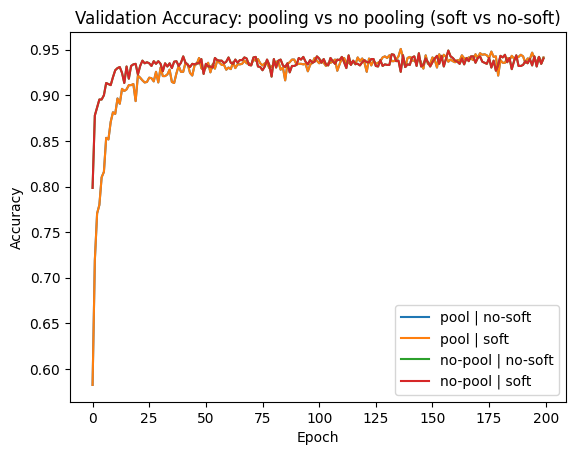

In [64]:
batch_size = 64
train_dataset = BloodMNIST(split="train", transform=transform, download=True, size=28)
val_dataset   = BloodMNIST(split="val",   transform=transform, download=True, size=28)
test_dataset  = BloodMNIST(split="test",  transform=transform, download=True, size=28)

#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
train_loader = DataLoader(
    train_dataset,
    batch_size=256,            #  128 ou 256
    shuffle=True,
    num_workers=4,             # 2, 4, 8
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)


epochs = 200
lr = 1e-3
use_pooling_flags = [True, False]

results = {
    "train_loss": {},
    "val_acc_no_soft": {},
    "val_acc_soft": {},
    "test_acc_no_soft": {},
    "test_acc_soft": {},
    "time_sec": {},
    "params": {},
    "best_val": {},
    "best_epoch" : {},
    "total_time" : {}

}

global_start = time.time()

for pool_flag in use_pooling_flags:
    tag = "with_pooling" if pool_flag else "no_pooling"
    print("\n" + "="*70)
    print("EXPERIMENT:", tag)
    print("="*70)

    model = CNN(num_classes=n_classes, use_pool=pool_flag).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    results["best_val"][tag] = 0.0
    results["best_epoch"][tag] = 0

    print("Trainable params:", count_params(model))

    train_losses = []
    val_no_soft_list = []
    val_soft_list = []



    exp_start = time.time()

    for epoch in range(epochs):
        t0 = time.time()

        tr_loss = train_epoch(train_loader, model, criterion, optimizer, use_pool_flag=pool_flag)
        val_no_soft, val_soft = evaluate_both(val_loader, model, use_pool_flag=pool_flag)

        train_losses.append(tr_loss)
        val_no_soft_list.append(val_no_soft)
        val_soft_list.append(val_soft)
        dt = time.time() - t0

        print(
            f"Epoch {epoch+1:03d}/{epochs} | "
            f"Loss: {tr_loss:.4f} | "
            f"ValAcc no-soft: {val_no_soft:.4f} | "
            f"ValAcc soft: {val_soft:.4f} | "
            f"Time: {dt:.2f}s"
        )
        if val_soft > results["best_val"][tag]:
            results["best_val"][tag] = val_soft
            torch.save(model.state_dict(), f"bloodmnist_cnn_{tag}.pth")
            results["best_epoch"][tag] = epoch
            print(f"Best model saved: bloodmnist_cnn_{tag}.pth | With val: {results["best_val"][tag]}" )

    test_no_soft, test_soft = evaluate_both(test_loader, model, use_pool_flag=pool_flag)
    exp_time = time.time() - exp_start
    results["total_time"][tag] = f"Total time ({tag}): {exp_time/60:.2f} min ({exp_time:.2f} s)"
    print(f"TestAcc no-soft: {test_no_soft:.4f} | TestAcc soft: {test_soft:.4f}")
    print(results["total_time"][tag])




    # Store results
    results["train_loss"][tag] = train_losses
    results["val_acc_no_soft"][tag] = val_no_soft_list
    results["val_acc_soft"][tag] = val_soft_list
    results["test_acc_no_soft"][tag] = test_no_soft
    results["test_acc_soft"][tag] = test_soft
    results["time_sec"][tag] = exp_time
    results["params"][tag] = count_params(model)

    # Per-model plots
    ep = range(len(train_losses))

    plot(ep, train_losses, ylabel="Loss",
         name=f"CNN-training-loss_{tag}_lr{lr}")

    plot(ep, val_no_soft_list, ylabel="Accuracy",
         name=f"CNN-validation-accuracy_{tag}_no-softmax_lr{lr}")

    plot(ep, val_soft_list, ylabel="Accuracy",
         name=f"CNN-validation-accuracy_{tag}_softmax_lr{lr}")

    with open(f"results_{tag}.json", "w") as f:
        json.dump(results, f, indent=4)



# Comparison plots (same figure)
ep = range(epochs)

plot_compare(
    ep,
    {
        "with pooling": results["train_loss"]["with_pooling"],
        "no pooling": results["train_loss"]["no_pooling"],
    },
    ylabel="Loss",
    title="Training Loss: pooling vs no pooling",
    filename=f"COMPARE_training_loss_pool_vs_nopool_lr{lr}"
)

plot_compare(
    ep,
    {
        "pool | no-soft": results["val_acc_no_soft"]["with_pooling"],
        "pool | soft": results["val_acc_soft"]["with_pooling"],
        "no-pool | no-soft": results["val_acc_no_soft"]["no_pooling"],
        "no-pool | soft": results["val_acc_soft"]["no_pooling"],
    },
    ylabel="Accuracy",
    title="Validation Accuracy: pooling vs no pooling (soft vs no-soft)",
    filename=f"COMPARE_val_accuracy_pool_nopool_soft_nosoft_lr{lr}"
)

global_time = time.time() - global_start
print("\n" + "="*70)
print("DONE")
print("Total run time:", f"{global_time/60:.2f} min ({global_time:.2f} s)")
print("Params:", results["params"])
print("Test:", {
    k: (results["best_val"][k], results["best_val"][k])
    for k in results["best_val"].keys()
})